In [1]:
import os
os.chdir("..")
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
import imb
import pickle
dirname = "mouse_brain_sagittal_anterior"
GPU_ID = 1
with open(dirname + "/train_data.pkl", "rb") as file:
    train_data = pickle.load(file)
with open(dirname + "/test_data.pkl", "rb") as file:
    test_data = pickle.load(file)
import datapre as DP
DP.setup_seed(1)

In [2]:
import cupy as cp
mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()

In [3]:
with cp.cuda.Device(GPU_ID):
    pos_index, neg_index, marked_neg_index = imb.eliminate_BD_neg(train_data.feature, train_data.label, k = 20)
    mempool.free_all_blocks()
    pinned_mempool.free_all_blocks()
    marked_neg_index = cp.asnumpy(marked_neg_index)

In [4]:
marked_feature = train_data.get_feature(train_data.pair_index_son[marked_neg_index], copy = True)
marked_label = train_data.get_label(train_data.data_index[marked_neg_index], copy = True)

In [5]:
train_data.pop(marked_neg_index)
train_data.mirror_copy()
train_data.get_feature()
train_data.get_label()

In [6]:
from model import nn_model
import evaluation as eval
model = nn_model.NeuralNetworkClassifier(batch_size = 128, dropout_rate=0.0)
model.fit(train_data.feature, train_data.label, marked_feature, marked_label)

Valid: 100%|██████████| 776/776 [00:01<00:00, 436.19it/s, val_loss=0.0011]


Validation loss decreased (inf --> 0.001101)
----------------------------------------------------------------


Valid: 100%|██████████| 776/776 [00:01<00:00, 490.62it/s, val_loss=0.0026]


EarlyStopping counter: 1 out of 7
----------------------------------------------------------------


Valid: 100%|██████████| 776/776 [00:01<00:00, 488.26it/s, val_loss=0.0007]


Validation loss decreased (0.001101 --> 0.000669)
----------------------------------------------------------------


Valid: 100%|██████████| 776/776 [00:01<00:00, 462.67it/s, val_loss=0.0005]


Validation loss decreased (0.000669 --> 0.000521)
----------------------------------------------------------------


Valid: 100%|██████████| 776/776 [00:01<00:00, 459.83it/s, val_loss=0.0003]


Validation loss decreased (0.000521 --> 0.000327)
----------------------------------------------------------------


Valid: 100%|██████████| 776/776 [00:01<00:00, 436.66it/s, val_loss=0.0003]


Validation loss decreased (0.000327 --> 0.000256)
----------------------------------------------------------------


Valid: 100%|██████████| 776/776 [00:01<00:00, 453.19it/s, val_loss=0.0009]


EarlyStopping counter: 1 out of 7
----------------------------------------------------------------


Valid: 100%|██████████| 776/776 [00:01<00:00, 441.21it/s, val_loss=0.0012]


EarlyStopping counter: 2 out of 7
----------------------------------------------------------------


Valid: 100%|██████████| 776/776 [00:01<00:00, 459.01it/s, val_loss=0.0011]


EarlyStopping counter: 3 out of 7
----------------------------------------------------------------


Valid: 100%|██████████| 776/776 [00:01<00:00, 494.54it/s, val_loss=0.0007]


EarlyStopping counter: 4 out of 7
----------------------------------------------------------------


Valid: 100%|██████████| 1819/1819 [00:20<00:00, 90.54it/s, val_loss=0.253]


Validation loss decreased (inf --> 0.252570)
----------------------------------------------------------------


Valid: 100%|██████████| 1819/1819 [00:17<00:00, 103.59it/s, val_loss=0.252]


Validation loss decreased (0.252570 --> 0.252049)
----------------------------------------------------------------


Valid: 100%|██████████| 1819/1819 [00:19<00:00, 94.86it/s, val_loss=0.261]


EarlyStopping counter: 1 out of 7
----------------------------------------------------------------


Valid: 100%|██████████| 1819/1819 [00:18<00:00, 97.61it/s, val_loss=0.274]


EarlyStopping counter: 2 out of 7
----------------------------------------------------------------


Valid: 100%|██████████| 1819/1819 [00:03<00:00, 489.93it/s, val_loss=0.27]


EarlyStopping counter: 3 out of 7
----------------------------------------------------------------


Valid: 100%|██████████| 1819/1819 [00:04<00:00, 448.24it/s, val_loss=0.305]


EarlyStopping counter: 4 out of 7
----------------------------------------------------------------


Valid: 100%|██████████| 1819/1819 [00:04<00:00, 434.61it/s, val_loss=0.294]


EarlyStopping counter: 5 out of 7
----------------------------------------------------------------


Valid: 100%|██████████| 1819/1819 [00:04<00:00, 424.58it/s, val_loss=0.295]


EarlyStopping counter: 6 out of 7
----------------------------------------------------------------


Valid: 100%|██████████| 1819/1819 [00:04<00:00, 422.44it/s, val_loss=0.299]


EarlyStopping counter: 7 out of 7
Early stopping
----------------------------------------------------------------


NeuralNetworkClassifier(batch_size=128, dropout_rate=0.0)

In [7]:
# train_data(无marked_neg_index)
predprob = model.predict_proba(train_data.feature)
eval.evaluate(train_data.label, predprob, verbose = False)

/data/huggs/nwt/SpaProx/evaluation.py:441: RuntimeWarning: invalid value encountered in long_scalars
  Precision = TP / (TP + FP)


{'Accuracy': 0.9899282851187844,
 'Precision': nan,
 'Recall': 0.0,
 'MCC': 0.0,
 'F1_Score': nan,
 'AUC': 0.9999943634846826,
 'Average Precision': 0.9997494214691033,
 'confusion_matrix': array([[982683,      0],
        [  9998,      0]])}

In [8]:
# marked_neg_index
predprob = model.predict_proba(marked_feature)
eval.evaluate(marked_label, predprob, verbose = False)

IndexError: index 1 is out of bounds for axis 0 with size 1

In [9]:
# 全部test_data
predprob = model.predict_proba(test_data.feature)
eval.evaluate(test_data.label, predprob, verbose = False)

{'Accuracy': 0.8536185004586492,
 'Precision': 0.014213386594825584,
 'Recall': 0.996742671009772,
 'MCC': 0.10988771739059475,
 'F1_Score': 0.028027111192526107,
 'AUC': 0.9514904524716428,
 'Average Precision': 0.024385805183391354,
 'confusion_matrix': array([[123461,  21223],
        [     1,    306]])}

In [10]:
with cp.cuda.Device(GPU_ID):
    pos_index, neg_index, marked_neg_index_test = imb.eliminate_BD_neg(test_data.feature, test_data.label, k = 20)
    mempool.free_all_blocks()
    pinned_mempool.free_all_blocks()
    marked_neg_index_test = cp.asnumpy(marked_neg_index_test)

In [11]:
test_data.pop(marked_neg_index_test)
test_data.mirror_copy()
test_data.get_feature()
test_data.get_label()

In [12]:
# test_data(去除marked_neg_index)
predprob = model.predict_proba(test_data.feature)
eval.evaluate(test_data.label, predprob, verbose = True)

{'Accuracy': 0.9975298972798747,
 'Precision': 0.8877551020408163,
 'Recall': 0.99185667752443,
 'MCC': 0.9371636510319111,
 'F1_Score': 0.936923076923077,
 'AUC': 0.9994323692107383,
 'Average Precision': 0.9488348475820582,
 'confusion_matrix': array([[32506,    77],
        [    5,   609]])}

In [13]:
import torch
import torch.nn.functional as F
num_classes = 2
input, target = model.test_forward(marked_feature, marked_label)

In [14]:
def custom_loss_grad(input, target):
    target = F.one_hot(target, num_classes = num_classes).detach()
    y = F.softmax(input, dim = 1).detach()
    return y - target

grad = custom_loss_grad(input, target)/2.0

In [15]:
# g: 梯度向量的l1范数
g = torch.abs(grad).sum(dim = 1).view(-1, 1)
g_np = g.reshape(-1).cpu().numpy()
target = target.cpu().numpy()

<Axes: ylabel='Density'>

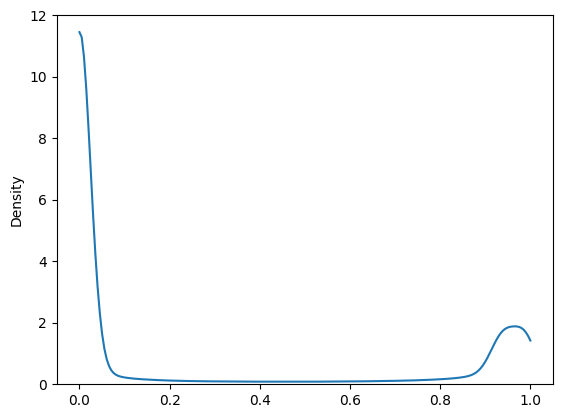

In [16]:
import matplotlib
matplotlib.use("module://matplotlib_inline.backend_inline")
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# plt.hist(g[g>0.5][target[g>0.5] == 1] ,bins=20, alpha = 0.5)
# plt.hist(g_np[g_np>0.5] ,bins=20, alpha = 0.5, kind = "kde")
sns.kdeplot(g_np, clip = (0.0, 1.0))
# plt.show()

In [17]:
bins = 30
edges = torch.arange(bins + 1).float() / bins
edges[-1] += 1e-6
edges = edges.view(1, -1).to(device="cuda:1")
# 批量样本的梯度范数g在bins上的落点，BxN
g_bin = torch.logical_and(torch.ge(g, edges[:, :-1]), torch.less(g, edges[:, 1:]))

In [18]:
# 批量样本的梯度范数g归属bins的index，(B, )
bin_idx = torch.where(g_bin)[1]
# 每个bins的counts，(N, )
bin_count = torch.sum(g_bin, dim = 0)

In [19]:
import scanpy as sc
adata = sc.datasets.visium_sge(sample_id = "V1_Mouse_Brain_Sagittal_Anterior")
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars = ["mt"], inplace = True)
with open(dirname + "/clusters.pkl", "rb") as file:
    adata.obs["clusters"] = pickle.load(file)

/home/huggs/anaconda3/envs/rapids_nwt/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [31]:
import numpy as np
selected = np.random.choice(marked_neg_index[g_np>0.98], 100)

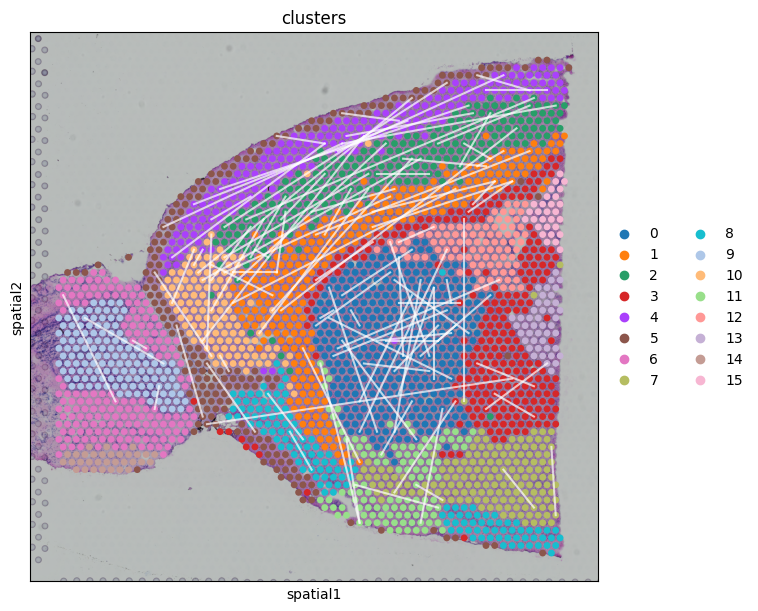

In [32]:
with open(dirname + "/train_data.pkl", "rb") as file:
    train_data = pickle.load(file)
import utils
utils.spot_plot(adata, pair_index = train_data.pair_index[selected])

In [2]:
with open(dirname + "/result3.pkl", "rb") as file:
    result = pickle.load(file)
result

FileNotFoundError: [Errno 2] No such file or directory: 'mouse_brain_sagittal_anterior/result3.pkl'

In [8]:
import torch
target = torch.tensor([1,0,1])
logpt = torch.tensor([[1.0, 2.1], [1.2, 3.1], [2.2, 2.4]])
logpt = logpt.gather(1, target.view(-1, 1))
logpt = logpt.view(-1)
pt = torch.exp(logpt)
alpha = torch.tensor([0.4, 0.6])
alpha = alpha.gather(0, target.view(-1))

In [12]:
loss = -1 * alpha * torch.pow((1 - pt), 2) * logpt

使用全部数据训练：所有样本预测成负样本
使用marked_neg_index方法：选择后的训练样本训练模型，能够很好的预测选择后的训练样本和测试样本，但是对于marked_neg_index的样本（训练和预测）预测很差

可以调整k，看上面marked_neg_index一例，大部分样本都能预测对，还可以调整